In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from scipy import stats
from itertools import cycle
from activation_utils import *
from plotting import *

matplotlib.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2

In [2]:
FIG_SIZE = (6,4)
FIG_DIR = 'final-figures/'
FONTSIZE = 13
plt.style.use('grayscale')

### Hyperplane Analysis

0.1
0.03162277660168379
0.01
0.0031622776601683794
0.001
0.00031622776601683794
0.0001
3.1622776601683795e-05
0.1
0.03162277660168379
0.01
0.0031622776601683794
0.001
0.00031622776601683794
0.0001
3.1622776601683795e-05


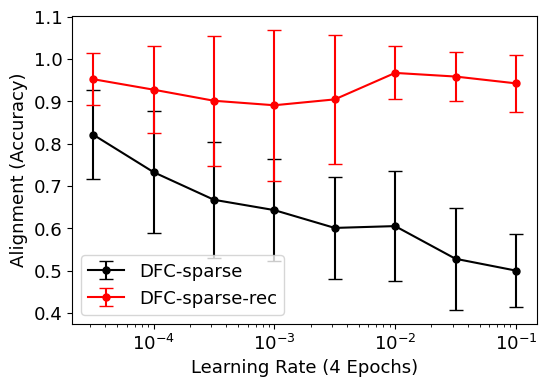

In [3]:
### Hyperplane alignment dfc-sparse vs. dfc-sparse-rec 
### Target activations with controller and recurrent effects are used
names, distance_means, distance_stds = run_hyperplane_analysis(
    cross_linear_separability,
    ['dfc-sparse', 'dfc-sparse-rec'],  
    activation_types=['-controller', '-controller'],
    mode='across_task_before_learned',
    layer=1,
    num_tasks=5,
    num_seeds=5
)
plot_hyperplane_results(names, distance_means, distance_stds, ylabel='Alignment (Accuracy)', fontsize=FONTSIZE)
plt.savefig(f'{FIG_DIR}hyperplane-alignment.svg', format='svg')

0.1
0.03162277660168379
0.01
0.0031622776601683794
0.001
0.00031622776601683794
0.0001
3.1622776601683795e-05
0.1
0.03162277660168379
0.01
0.0031622776601683794
0.001
0.00031622776601683794
0.0001
3.1622776601683795e-05


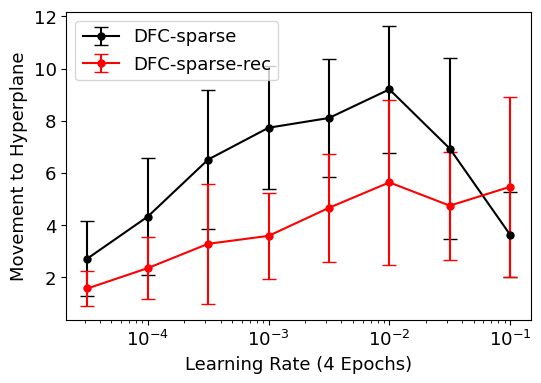

In [4]:
### Normalized movement towards hyperplane dfc-sparse vs. dfc-sparse-rec
### Movement of feedforward activations is considered, hyperplane is comptued with target activations
### (i.e. including controller and recurrent effects)
names, distance_means, distance_stds = run_hyperplane_analysis(
    movement_towards_hyperplane_normalized,
    ['dfc-sparse', 'dfc-sparse-rec'],  
    activation_types=['-feedforward', '-feedforward'],
    activation_types_hyp=['-controller', '-controller'],
    mode='across_time',
    layer=1,
    num_tasks=5,
    num_seeds=5
)
plot_hyperplane_results(names, distance_means, distance_stds, ylabel='Movement to Hyperplane')
plt.savefig(f'{FIG_DIR}movement-towards-hyperplane.svg', format='svg')

### Separation analysis

In [5]:
### compute domain-IL feedforward activation separation data (no controller or recurrent effects)
chosen_lr_exponents = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
lrs = [10 ** (-neg_exp) for neg_exp in chosen_lr_exponents]
task_overlap_vals, tgt_overlap_vals, all_overlap_vals = compute_activation_overlaps('domain',
                                                                        lrs,
                                                                        record_str='-feedforward',
                                                                        mode='across_task',
                                                                        layer=1)

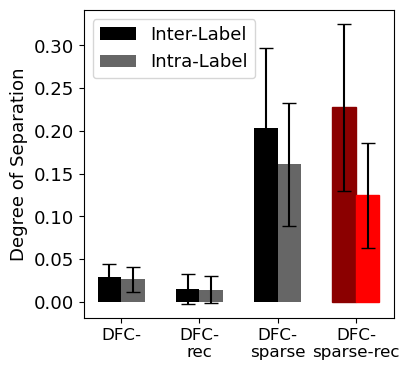

In [6]:
### inter and intra label separation bar plot
width = 0.3
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
fig1.patch.set_facecolor('white')
intra_tgt_separation_means = []
intra_task_separation_means = []
intra_tgt_separation_stds = []
intra_task_separation_stds = []
for name in tgt_overlap_vals.keys():
    overlap_mean_diffs, inter_tgt_overlap_means, inter_task_overlap_means = compute_mean_digit_separations_domainIL(name, 5, tgt_overlap_vals, task_overlap_vals)
    intra_tgt_separation_means.append(inter_tgt_overlap_means.mean())
    intra_task_separation_means.append(inter_task_overlap_means.mean())
    intra_tgt_separation_stds.append(inter_tgt_overlap_means.std())
    intra_task_separation_stds.append(inter_task_overlap_means.std())
barlist_inter = ax1.bar(np.arange(len(tgt_overlap_vals)) - width/2, intra_tgt_separation_means,
                          width, yerr=intra_tgt_separation_stds, label='Inter-Label', capsize=5)
barlist_intra = ax1.bar(np.arange(len(task_overlap_vals)) + width/2, intra_task_separation_means,
                          width, yerr=intra_task_separation_stds, label='Intra-Label', capsize=5)
barlist_inter[-1].set_color('darkred')
barlist_intra[-1].set_color('r')
ax1.legend(prop={'size': FONTSIZE}, loc='upper left')

plt.sca(ax1)
modes_to_plot = ['DFC-\n' + ('-').join(mode.split('-')[1:]) if mode.startswith('dfc') else mode for mode in tgt_overlap_vals.keys()]
plt.xticks(range(len(tgt_overlap_vals)), modes_to_plot, fontsize=FONTSIZE-1)
plt.yticks(fontsize=FONTSIZE)
ax1.set_ylabel('Degree of Separation', fontsize=FONTSIZE)

fig1.savefig(f'{FIG_DIR}representational-separation-domainIL.svg', format='svg')

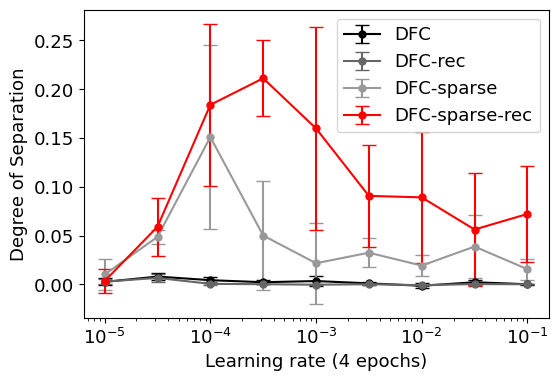

In [7]:
### inter-target minus intra-target separation
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
fig2.patch.set_facecolor('white')
capsize=5
include_all_variants = True



if include_all_variants:
    plot_normalized_separation_domainIL('dfc', ax2, 5, tgt_overlap_vals, task_overlap_vals, lrs)
    plot_normalized_separation_domainIL('dfc-rec', ax2, 5, tgt_overlap_vals, task_overlap_vals, lrs)
sparse_overlap_diff = plot_normalized_separation_domainIL('dfc-sparse', ax2, 5, tgt_overlap_vals, task_overlap_vals, lrs)
sparse_rec_overlap_diff = plot_normalized_separation_domainIL('dfc-sparse-rec', ax2, 5, tgt_overlap_vals, task_overlap_vals, lrs)
plt.legend(prop={'size': FONTSIZE})
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

ax2.set_xscale('log')
ax2.set_xlabel('Learning rate (4 epochs)', fontsize=FONTSIZE)
ax2.set_ylabel('Degree of Separation', fontsize=FONTSIZE)
ax2.legend(prop={'size': FONTSIZE})

fig2.savefig(f'{FIG_DIR}information-distance-domainIL.svg', format='svg')

In [8]:
### compute class-IL target separation data
neg_lr_exponents = [1.0, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5.0]
lrs = [10 ** (-neg_exp) for neg_exp in neg_lr_exponents]
_, _, all_overlap_vals = compute_activation_overlaps('class',
                                                     lrs,
                                                     record_str='-controller',
                                                     mode='across_task_first_learned',
                                                     layer=1)

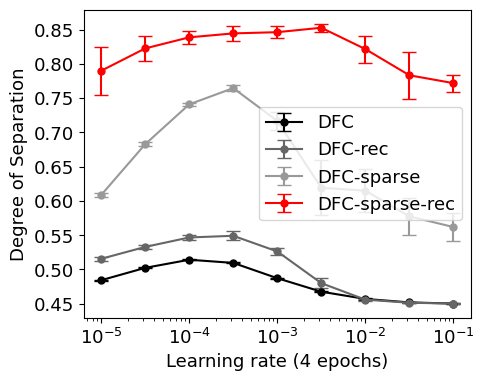

In [9]:
### class-IL inter-digit target separation, (targets include controller and recurrent effects), when first learned

plt.style.use('grayscale')
plt.rcParams["figure.figsize"] = (5,4)
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.patch.set_facecolor('white')







plot_digit_separation_classIL('dfc', ax, lrs, all_overlap_vals)
plot_digit_separation_classIL('dfc-rec', ax, lrs, all_overlap_vals)
plot_digit_separation_classIL('dfc-sparse', ax, lrs, all_overlap_vals)
plot_digit_separation_classIL('dfc-sparse-rec', ax, lrs, all_overlap_vals)

ax.set_xlabel('Learning rate (4 epochs)', fontsize=FONTSIZE)
ax.set_xscale('log')
ax.set_ylabel('Degree of Separation', fontsize=FONTSIZE)
ax.legend(prop={'size': FONTSIZE}, loc='center right')
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
fig.savefig(f'{FIG_DIR}representational-separation-ctr-first_learned-classIL.svg', format='svg')